In [3]:
import glob,os
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from astropy.coordinates import SkyCoord


# Visualisation challenge

How can we visualizze in the science portal and in general a 6-band light-curve?

- which color scheme?
- dynamic, non-dinamic plot
- only detections? 
- add forced photometry?
- different markers?
- projections?
- different profile tabs different visualisation?



The y band in Rubin is y but in SNANA is Y. Why? need to ask the SNANA developer

In [4]:
def in_colab():
    try:
        import google.colab
        print('You are in Google Collab')
        return True
    except ImportError:
        return False

if in_colab():
    print('Adding data to repository')
    repo_url = "https://github.com/Fink-analyses/Tutorial_LSST_sims_2025.git"
    repo_name = "Tutorial_LSST_sims_2025"
    
    if not os.path.exists(repo_name):
        print("Cloning repo...")
        !git clone $repo_url
    
    # cd only if not already inside
    current_path = os.path.basename(os.getcwd())
    if current_path != repo_name:
        %cd $repo_name


# Useful definitions

In [5]:
# Useful functions
def convert_fluxcal_to_mag(df):
    """Convert fluxcal to magnitude and add magnitude error

    Args:
        df (pd.DataFrame): DataFrame with columns "FLUXCAL" and "FLUXCALERR"
    Returns:
        pd.DataFrame: DataFrame with added "magnitude" and "magnitude error"
    """
    # Convert fluxcal to magnitude
    df = df.copy()
    flux = df["FLUXCAL"].copy()
    flux[flux <= 0] = np.nan

    # Compute magnitude; where flux was <= 0, magnitude will be NaN
    df["magnitude"] = -2.5 * np.log10(flux) + 27.5
    df["magnitude error"] = 2.5 / np.log(10) * df["FLUXCALERR"] / df["FLUXCAL"]
    return df

def read_fits(fname, drop_separators=False):
    """Load SNANA formatted data and cast it to a PANDAS dataframe

    Args:
        fname (str): path + name to PHOT.FITS file
        drop_separators (Boolean): if -777 are to be dropped

    Returns:
        (pandas.DataFrame) dataframe from PHOT.FITS file (with ID)
        (pandas.DataFrame) dataframe from HEAD.FITS file
    """

    # load photometry
    dat = Table.read(fname, format="fits")
    df_phot = dat.to_pandas()
    # failsafe
    if df_phot.MJD.values[-1] == -777.0:
        df_phot = df_phot.drop(df_phot.index[-1])
    if df_phot.MJD.values[0] == -777.0:
        df_phot = df_phot.drop(df_phot.index[0])

    # load header
    header = Table.read(fname.replace("PHOT", "HEAD"), format="fits")
    df_header = header.to_pandas()
    df_header["SNID"] = df_header["SNID"].astype(np.int32)
    folder = os.path.basename(os.path.dirname(fname))
    # Add new column with this extracted SN type for all rows
    df_header['SN_TYPE_FROM_PATH'] = folder

    # add SNID to phot for skimming
    arr_ID = np.zeros(len(df_phot), dtype=np.int32)
    # New light curves are identified by MJD == -777.0
    arr_idx = np.where(df_phot["MJD"].values == -777.0)[0]
    arr_idx = np.hstack((np.array([0]), arr_idx, np.array([len(df_phot)])))
    # Fill in arr_ID
    for counter in range(1, len(arr_idx)):
        start, end = arr_idx[counter - 1], arr_idx[counter]
        # index starts at zero
        arr_ID[start:end] = df_header.SNID.iloc[counter - 1]
    df_phot["SNID"] = arr_ID

    if drop_separators:
        df_phot = df_phot[df_phot.MJD != -777.000]

    df_phot['SNR'] = df_phot['FLUXCAL'] / df_phot['FLUXCALERR']

    # Add a column for latest MJD per SNID where SNR > 5
    df_max_mjd = (
    df_phot[df_phot.SNR > 5]
    .groupby('SNID', as_index=False)['MJD']
    .max()
    .rename(columns={'MJD': 'max_MJD_SNR_gt_5'})
    )
    df_phot_with_last_mjd = df_phot.copy()
    df_phot_with_last_mjd = df_phot_with_last_mjd.merge(df_max_mjd,on='SNID')

    # convert to magnitude
    df_phot_with_last_mjd = convert_fluxcal_to_mag(df_phot_with_last_mjd)

    df_header_with_DDF = tag_DDF(df_header)

    return df_header_with_DDF, df_phot_with_last_mjd



def tag_DDF(df_header):
    """Tag DDF fields in the header DataFrame
    Approximation using a 3 degree radius around the field center.

    Args:
        df_header (pd.DataFrame): DataFrame with header information

    Returns:
        pd.DataFrame: Updated df_header with DDF field tags
    """

    # Rubin DDFs coordinates
    dff_coords_dic = {
        'Field': ['ELAISS1', 'XMM_LSS', 'ECDFS', 'COSMOS', 'EDFS_a', 'EDFS_b'],
        'RA': [9.45, 35.57, 52.98, 150.11, 58.9, 63.6],
        'DEC': [-44.02, -4.82, -28.12, 2.23, -49.32, -47.6],
        'Gal l': [311.29, 171.1, 224.07, 236.78, 257.9, 254.48],
        'Gal b': [-72.88, -58.91, -54.6, 42.13, -48.46, -45.77],
        'Eclip l': [346.66, 31.59, 40.81, 151.39, 32, 40.97],
        'Eclip b': [-43.2, -17.92, -45.44, -9.34, -66.61, -66.6]
    }

    ddf_fields = pd.DataFrame(dff_coords_dic)
    
    # Initialize new columns[]
    df_header["in_ddf_field"] = False
    df_header["ddf_field_name"] = np.nan

    # Convert df_header RA/DEC to SkyCoord
    coords_header = SkyCoord(ra=df_header["RA"].values * u.deg,
                            dec=df_header["DEC"].values * u.deg)

    # Loop through DDF fields
    for _, row in ddf_fields.iterrows():
        field = row["Field"]
        ra = row["RA"]
        dec = row["DEC"]
        
        # Convert field center to SkyCoord
        field_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
        
        # Compute angular separation
        separation = coords_header.separation(field_coord)
        
        # Find objects within radius (approximation of cirdular footprint)
        radius = 3 # degrees
        within = separation <= radius * u.deg
        
        df_header.loc[within, "in_ddf_field"] = True
        df_header.loc[within, "ddf_field_name"] = field
    return df_header


# Read simulations

In [6]:
df_header_list=[]
df_phot_list=[]
list_to_read = glob.glob("sims/*/*PHOT.FITS.gz")
print(f"Found {len(list_to_read)} PHOT.FITS.gz files to read.")
for fphot in list_to_read:
    print(f"Reading {fphot}")
    df_header_tmp, df_phot_tmp = read_fits(fphot, drop_separators=True)
    df_header_list.append(df_header_tmp)
    df_phot_list.append(df_phot_tmp)
df_header = pd.concat(df_header_list, ignore_index=True)
# Read all PHOT.FITS.gz files and concatenate them    
df_phot = pd.concat(df_phot_list, ignore_index=True)

print("")
print(f"Number of light curves: {len(df_header)}")
print(f"Number of photometric points per light-curve: {df_phot.groupby('SNID').count()['MJD'].median()} +- {np.round(df_phot.groupby('SNID').count()['MJD'].std(),2)}")
# Total per SNTYPE
total_counts = df_header.groupby('SN_TYPE_FROM_PATH')['SNID'].count()

# In DDF per SNTYPE
ddf_counts = df_header[df_header['in_ddf_field']].groupby('SN_TYPE_FROM_PATH')['SNID'].count()

# Combine into a DataFrame
summary_df = pd.DataFrame({
    'Total': total_counts,
    'In DDF': ddf_counts,
})

# Fill missing DDF entries with 0
summary_df['In DDF'] = summary_df['In DDF'].fillna(0).astype(int)

# Compute percentage
summary_df['% in DDF'] = (summary_df['In DDF'] / summary_df['Total'] * 100).round(1)

# Display
print(summary_df)


Found 9 PHOT.FITS.gz files to read.
Reading sims/AGN/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIIn/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIc/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIb/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SLSN/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/KN/PIP_AMR_KN_LSST_KN_KASEN_81c4b_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNII/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz
Reading sims/SNIa/AMR_ELASTICC2_LSST_NONIaMODEL00-0012_PHOT.FITS.gz
Reading sims/TDE/AMR_ELASTICC2_LSST_NONIaMODEL00-0001_PHOT.FITS.gz

Number of light curves: 68483
Number of photometric points per light-curve: 75.0 +- 257.3
                   Total  In DDF  % in DDF
SN_TYPE_FROM_PATH                         
AGN                 1241      13       1.0
KN                  5764      60       1.0
SLSN                 880      11       1.2
SNII               13991     303     

You can choose which type to plot, I choose a SN Ib for simplicity

In [7]:
df_header['SN_TYPE_FROM_PATH'].unique()

array(['AGN', 'SNIIn', 'SNIc', 'SNIb', 'SLSN', 'KN', 'SNII', 'SNIa',
       'TDE'], dtype=object)

In [8]:
# example, taking the type you want
idx = df_header[df_header['SN_TYPE_FROM_PATH']=='SLSN'].SNID.iloc[0]

In [9]:
# I took a known id for SN Ib
idx = 2998840

# Matplotlib

In [10]:

# Define LSST band colors
band_colors = {
    'LSST-u': '#8c8cff',
    'LSST-g': '#377eb8',
    'LSST-r': '#4daf4a',
    'LSST-i': '#ff7f00',
    'LSST-z': '#e41a1c',
    'LSST-Y': '#a65628'
}

def plot_lc_matplotlib(df_phot, df_header, idx, inmag=False, convert_date=False):
    sel_header = df_header[df_header.SNID == idx]
    sel_phot = df_phot[df_phot.SNID == idx].copy()

    # Restrict to photometry received by broker
    snr5_df = sel_phot[sel_phot['SNR'] > 5]
    last_alert_mjd = snr5_df['MJD'].max()
    sel_phot = sel_phot[sel_phot['MJD'] <= last_alert_mjd]

    if len(sel_phot) == 0:
        print(f"No photometry for SNID {idx}")
        return

    if inmag:
        sel_phot = sel_phot[sel_phot["magnitude"] > 0]
        yvar = "magnitude"
        yerrvar = "magnitude error"
        ylabel = "Magnitude"
    else:
        yvar = "FLUXCAL"
        yerrvar = "FLUXCALERR"
        ylabel = "FLUXCAL"

    sel_phot["BAND"] = sel_phot["BAND"].str.decode("utf-8").str.strip()
    bands = sel_phot["BAND"].unique()

    if convert_date:
        sel_phot["TIME"] = pd.to_datetime(sel_phot["MJD"], unit="D", origin="1858-11-17")
        x_col = "TIME"
        xlabel = "Date"
    else:
        x_col = "MJD"
        xlabel = "MJD"

    fig, ax = plt.subplots(figsize=(8, 4))

    for band in bands:
        color = band_colors.get(band, "black")
        band_data = sel_phot[sel_phot["BAND"] == band]

        # Plot with error bars for SNR > 1
        mask_err = band_data["SNR"] > 1
        ax.errorbar(
            band_data.loc[mask_err, x_col],
            band_data.loc[mask_err, yvar],
            yerr=band_data.loc[mask_err, yerrvar],
            fmt='o',
            color=color,
            label=band,
            markersize=6,
            linestyle='none'
        )

        # Plot without error bars for SNR <= 1
        mask_noerr = band_data["SNR"] <= 1
        ax.plot(
            band_data.loc[mask_noerr, x_col],
            band_data.loc[mask_noerr, yvar],
            'o',
            color=color,
            markersize=6
        )

    # Title and labels
    z = np.round(float(sel_header["REDSHIFT_FINAL"].values[0]), 2)
    sim_type = sel_header["SIM_TYPE_NAME"].values[0]
    if isinstance(sim_type, bytes):
        sim_type = sim_type.decode("utf-8")
    ddf = sel_header["ddf_field_name"].values[0] if sel_header["in_ddf_field"].values[0] else "Not in DDF"

    ax.set_title(f"{sim_type} SNID: {idx} z: {z} {ddf}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if inmag:
        ax.invert_yaxis()
    ax.legend(title="Filter", fontsize='small', loc='best')
    plt.tight_layout()
    plt.show()

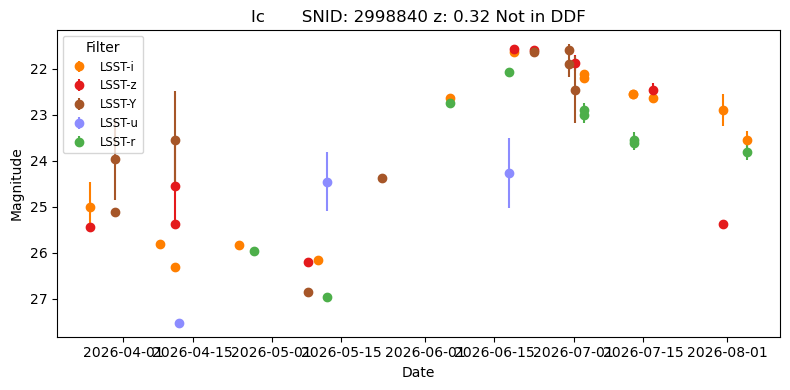

In [11]:
plot_lc_matplotlib(df_phot, df_header, idx, inmag=True, convert_date=True)

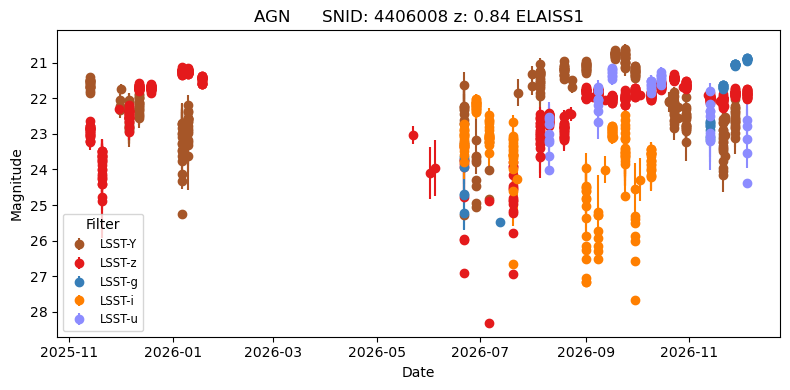

In [12]:
plot_lc_matplotlib(df_phot, df_header, 4406008, inmag=True, convert_date=True)

Just show the latest, the average (mean/median?), beyond visualisation what does your ML code need

# Plotly

In [13]:
# Useful plotting functions
band_colors = {
    'LSST-u': '#8c8cff',   # soft violet
    'LSST-g': '#377eb8',   # blue
    'LSST-r': '#4daf4a',   # green
    'LSST-i': '#ff7f00',   # orange
    'LSST-z': '#e41a1c',   # red
    'LSST-Y': '#a65628'    # brown
}

def plot_lc_plotly(df_phot, df_header, idx, inmag=False, convert_date=False):
    """Plot light curve for a given SNID

    Args:
        df_phot (pd.DataFrame): photometry
        df_header (pd.DataFrame): metadata
        idx (int64): SNID to plot
        inmag (bool, optional): Plot using magnitudes instead of FLUXCAL. Defaults to False.
        convert_date (bool, optional): Plot using human-dates instead of MJD. Defaults to False.
    """
    # Select data for the given SNID
    sel_header = df_header[df_header.SNID == idx]
    sel_phot = df_phot[df_phot.SNID == idx]

    # Restrict to photometry received by broker
    snr5_df = sel_phot[sel_phot['SNR'] > 5]
    last_alert_mjd = snr5_df['MJD'].max()
    sel_phot = sel_phot[sel_phot['MJD'] <= last_alert_mjd]

    if len(sel_phot)>0:

        if inmag: # selet only valid magnitudes
            sel_phot = sel_phot[sel_phot["magnitude"] > 0]
            yvar = "magnitude"
            yerrvar = "magnitude error"
        else:
            yvar = "FLUXCAL"
            yerrvar = "FLUXCALERR"

        ylabel = 'magnitude' if inmag else 'FLUXCAL'
        sel_phot["BAND"] = sel_phot["BAND"].str.decode('utf-8').str.strip()
        bands = sel_phot["BAND"].unique()

        # Convert MJD to datetime if requested
        if convert_date:
            sel_phot["TIME"] = pd.to_datetime(sel_phot["MJD"], unit='D', origin='1858-11-17')
            x_col = "TIME"
        else:
            x_col = "MJD"

        # Initialize the figure
        fig = go.Figure()
        for flt in bands:
            sel_phot_flt = sel_phot[sel_phot["BAND"] == flt]

            # Plot points based on SNR thresholds
            for snr_min, snr_max, symbol, opacity, name_suffix in [
                (5, np.inf, 'circle', 1, "SNR > 5"),
                (1, 5, 'square', 0.5, "1 < SNR < 5"),
            ]:
                mask = (sel_phot_flt['SNR'] > snr_min) & (sel_phot_flt['SNR'] < snr_max)
                fig.add_trace(go.Scatter(
                    x=sel_phot_flt.loc[mask, x_col],
                    y=sel_phot_flt.loc[mask, yvar],
                    error_y=dict(
                        type='data',
                        array=sel_phot_flt.loc[mask, yerrvar],
                        visible=True,
                        thickness=1.5 if snr_min < 5 else None,
                        width=0.5 if snr_min < 5 else None,
                    ),
                    mode='markers',
                    name=f"{flt}" if snr_min == 5 else None,
                    showlegend=(snr_min == 5),  # hides legend when name is None
                    marker=dict(opacity=opacity, symbol=symbol, size=8, color=band_colors.get(flt, 'black'))
                ))

            # SNR < 1 points, no error bars
            mask = sel_phot_flt['SNR'] < 1
            fig.add_trace(go.Scatter(
                x=sel_phot_flt.loc[mask, x_col],
                y=sel_phot_flt.loc[mask, yvar],
                mode='markers',
                name=None,
                showlegend=False,
                marker=dict(opacity=0.5, symbol='triangle-down', size=8,color=band_colors.get(flt, 'black'))
            ))

        z = np.round(float(sel_header.REDSHIFT_FINAL.values[0]), 2)
        sim_type_name = sel_header.SIM_TYPE_NAME.values[0]
        if isinstance(sim_type_name, bytes):
            sim_type_name = sim_type_name.decode("utf-8")
        if sel_header.in_ddf_field.values[0]:
            ddf_field_name = sel_header.ddf_field_name.values[0]
        else:
            ddf_field_name = "Not in DDF"
        fig.update_layout(
            title=f"{sim_type_name} SNID: {idx} z: {z} {ddf_field_name}",
            xaxis_title="Date" if convert_date else "MJD",
            yaxis_title=ylabel,
            height=300,
            width=600,
            legend_title="Filter"
        )

        if inmag:
            fig.update_yaxes(autorange="reversed")
        fig.show()


In [14]:
print("Plotting light curves for each SN type with >5 photometric points...")
print("Circles = SNR > 5, Squares = 1 < SNR < 5, Triangles = SNR < 1")
plot_lc_plotly(df_phot, df_header, idx, inmag=True, convert_date=True)

Plotting light curves for each SN type with >5 photometric points...
Circles = SNR > 5, Squares = 1 < SNR < 5, Triangles = SNR < 1


# Questions

- which color scheme?
- dynamic, non-dinamic plot
- only detections? 
- add forced photometry?
- different markers?
- projections?
- different profile tabs different visualisation?
- ...
- mean/median vs just last alert vs all?